In [39]:
import sys
sys.path.append("../src")
import simulation
import feature_extraction
import models

In [48]:
import importlib, simulation,feature_extraction
importlib.reload(simulation)
importlib.reload(feature_extraction)
importlib.reload(models)

<module 'models' from '/Users/dhruvmenon/Documents/BME590Project/notebooks/../src/models.py'>

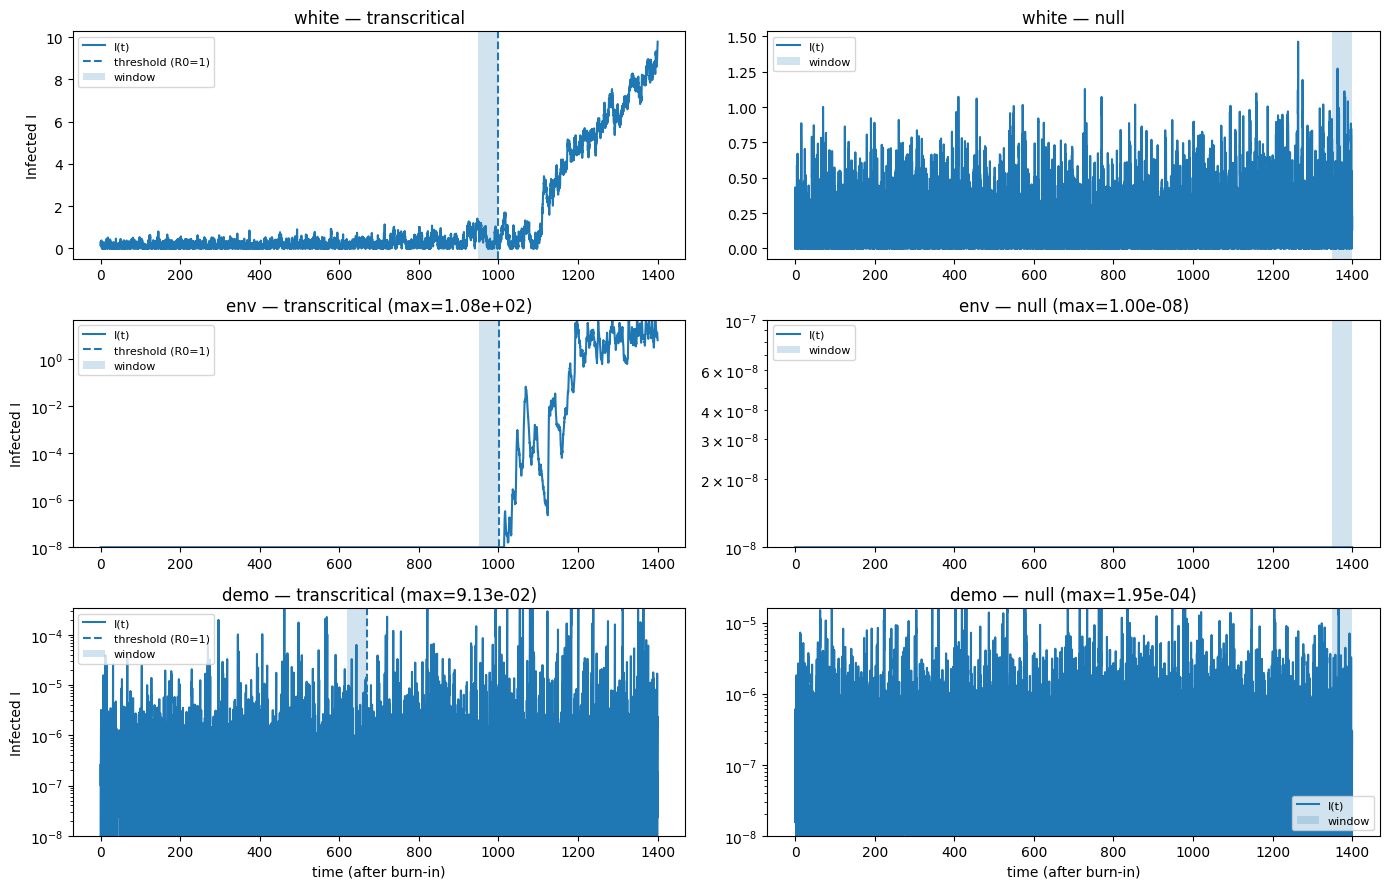

In [31]:
#one demo plot for each noise and transcritical/null
simulation.demo_plot(window_points=500,upper_q=99.5)



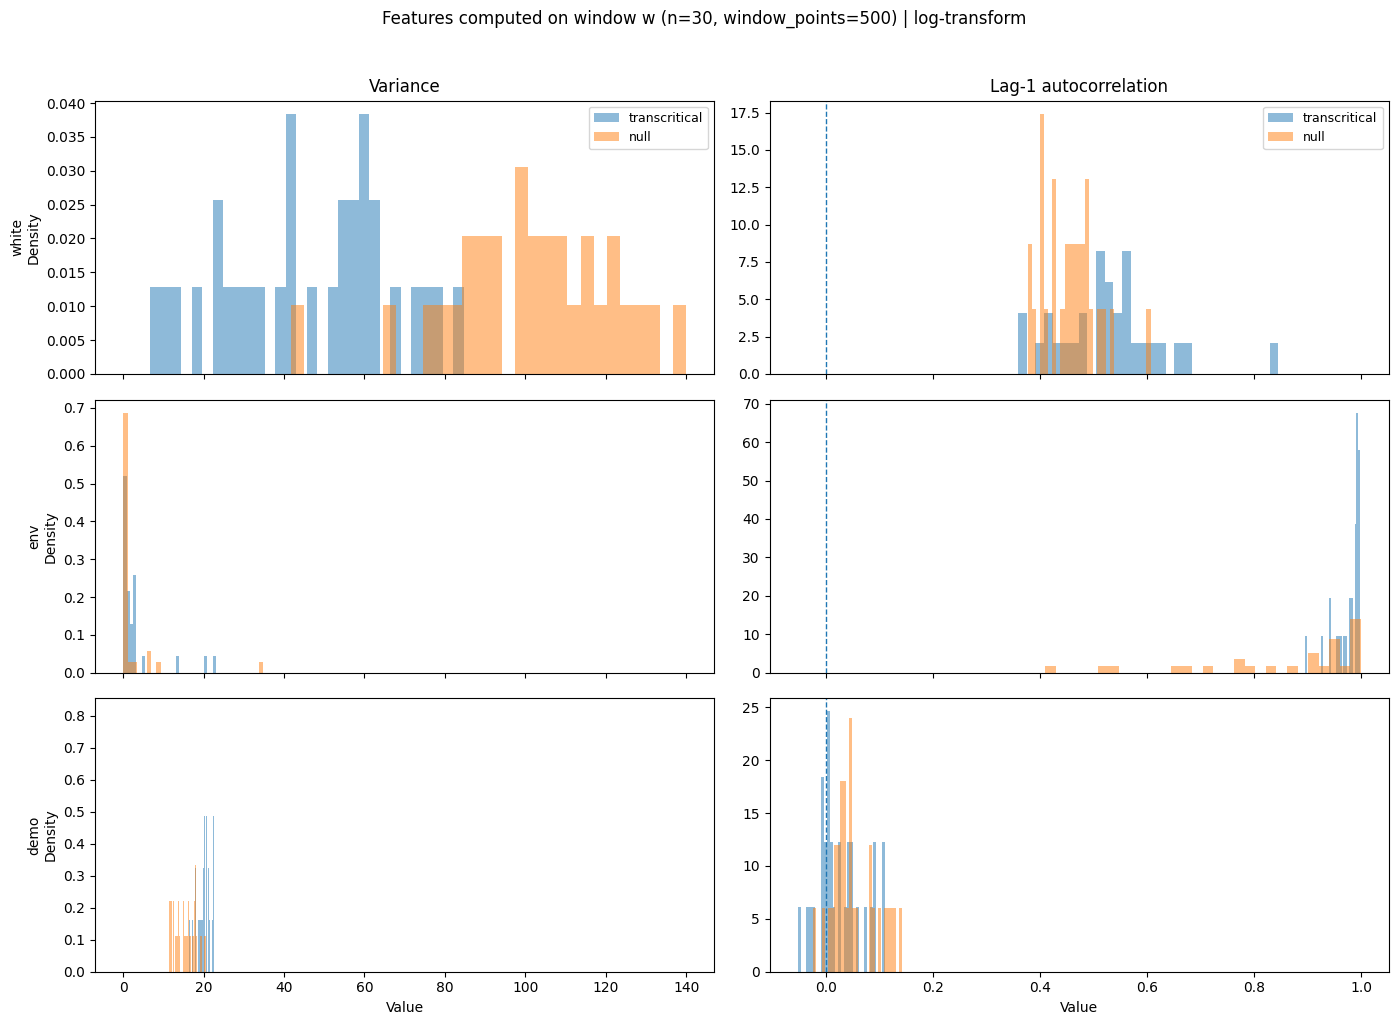

In [33]:
#extracts lag autocorrelation and variance for n number of runs and plots
results = feature_extraction.demo_feature_distributions(n=30, window_points=500, log_transform=True, eps=1e-12)

In [38]:
df = feature_extraction.build_ews_dataframe(noise="white", n=1000, window_points=500)

print(df.head())
print(df["label"].value_counts())  # should be 50/50 split

   variance       ac1        cv  skewness  kurtosis  label  noise
0  0.048476  0.948069  0.635247  0.099395  1.965951      1  white
1  0.060694  0.920447  0.739888  0.493747  2.380874      1  white
2  0.020620  0.993077  0.706600  0.576927  2.501271      1  white
3  0.059669  0.950495  0.764750  0.679524  2.922865      1  white
4  0.050635  0.921414  0.744135  0.415598  2.160607      1  white
label
1    500
0    500
Name: count, dtype: int64


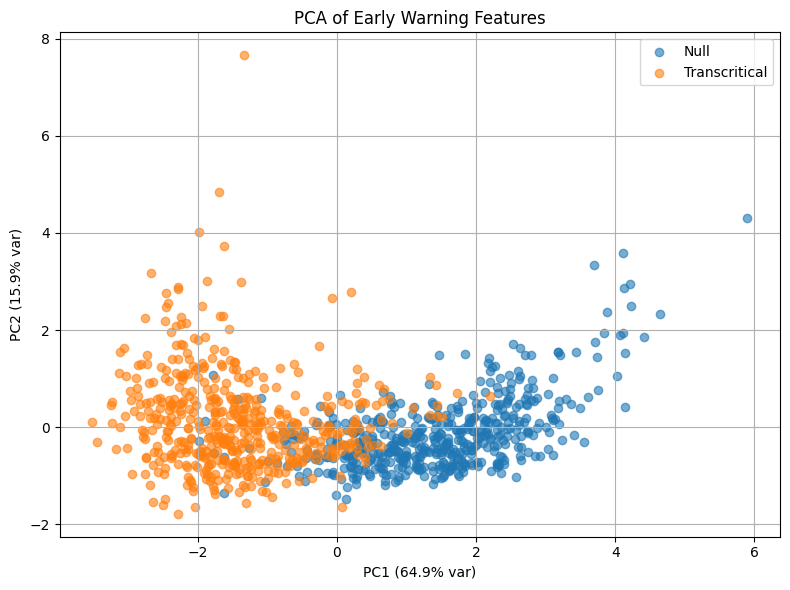

In [41]:
pca_model = models.plot_pca_ews(df)

In [42]:
df_env = feature_extraction.build_ews_dataframe(noise="env", n=1000, window_points=500)

print(df_env.head())
print(df_env["label"].value_counts())  # should be 50/50 split

       variance       ac1        cv  skewness   kurtosis  label noise
0  1.004325e-18  0.989702  2.224017  2.929659  11.555203      1   env
1  7.472925e-23  0.982090  1.753945  4.433573  26.076074      1   env
2  5.641301e-20  0.997878  2.461130  3.631885  19.283529      1   env
3  1.052296e-23  0.982787  1.205989  2.514205   9.381194      1   env
4  6.977565e-06  0.984891  2.369801  3.210089  12.991692      1   env
label
1    500
0    500
Name: count, dtype: int64


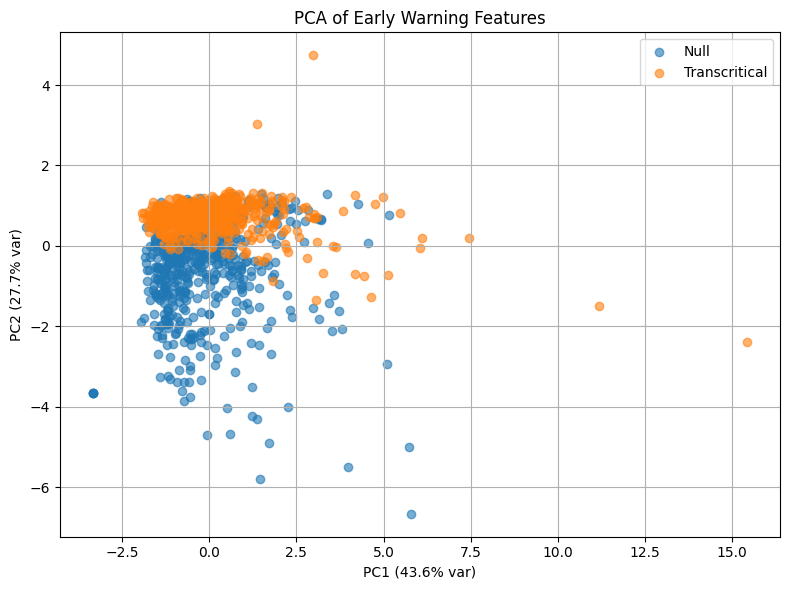

In [43]:
pca_model_env = models.plot_pca_ews(df_env)

In [44]:
df_demo = feature_extraction.build_ews_dataframe(noise="demo", n=1000, window_points=500)

print(df_demo.head())
print(df_demo["label"].value_counts())  # should be 50/50 split

       variance       ac1        cv   skewness    kurtosis  label noise
0  1.892331e-10  0.539605  5.333307  11.706731  169.965478      1  demo
1  1.215123e-09  0.729070  6.309365   9.420376  104.654468      1  demo
2  8.215910e-09  0.582880  9.849254  16.507577  307.443023      1  demo
3  3.858753e-11  0.470620  3.794958  12.706580  210.935069      1  demo
4  1.245775e-11  0.557807  2.875947   6.769644   60.210865      1  demo
label
1    500
0    500
Name: count, dtype: int64


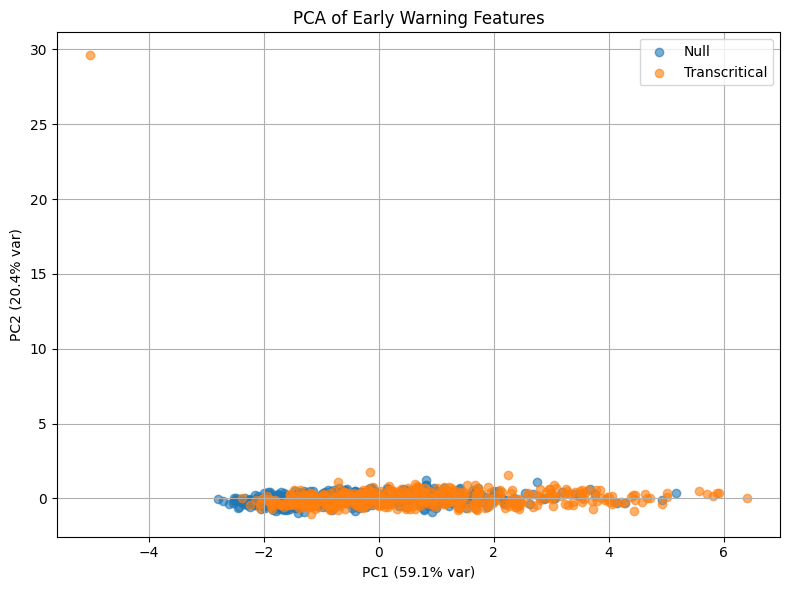

In [46]:
pca_model_env = models.plot_pca_ews(df_demo)

In [65]:
print(pca_model_env.explained_variance_ratio_)

[0.59060721 0.20424244]


In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

def plot_kernel_pca(df, kernel="rbf", gamma=None):

    feature_cols = ["variance", "ac1", "cv", "skewness", "kurtosis"]

    X = df[feature_cols].values
    y = df["label"].values

    # Scale first
    X_scaled = StandardScaler().fit_transform(X)

    kpca = KernelPCA(
        n_components=2,
        kernel=kernel,
        gamma=gamma,
        fit_inverse_transform=False
    )

    X_kpca = kpca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    plt.scatter(X_kpca[y==0,0], X_kpca[y==0,1], alpha=0.6, label="Null")
    plt.scatter(X_kpca[y==1,0], X_kpca[y==1,1], alpha=0.6, label="Transcritical")
    plt.title(f"Kernel PCA ({kernel})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

    return kpca
from sklearn.manifold import TSNE

def plot_tsne(df):

    feature_cols = ["variance", "ac1", "cv", "skewness", "kurtosis"]

    X = df[feature_cols].values
    y = df["label"].values

    X_scaled = StandardScaler().fit_transform(X)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    plt.scatter(X_tsne[y==0,0], X_tsne[y==0,1], alpha=0.6, label="Null")
    plt.scatter(X_tsne[y==1,0], X_tsne[y==1,1], alpha=0.6, label="Transcritical")
    plt.title("t-SNE Projection")
    plt.legend()
    plt.show()

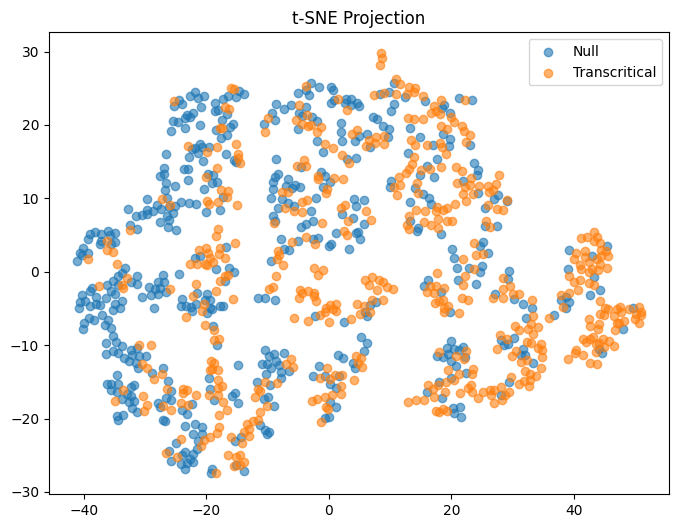

In [63]:
#plot_kernel_pca(df_demo, kernel="rbf", gamma=1)
#plot_kernel_pca(df_demo, kernel="rbf", gamma=5)
#plot_kernel_pca(df_demo, kernel="poly")
plot_tsne(df_demo)

PCA results indicate that separability decreases as complexity of noise increases. We will have to consider extracting more features for demographic noise and perhaps environmental noise or do more tests to see if this task is even possible. I'll go ahead with fitting some models for white noise.

In [56]:
from sklearn.model_selection import train_test_split

# Feature columns
feature_cols = ["variance", "ac1", "cv", "skewness", "kurtosis"]

# Put your datasets into a dictionary
datasets = {
    "white": df,
    "env": df_env,
    "demo": df_demo
}

splits = {}

for name, df in datasets.items():
    
    X = df[feature_cols]
    y = df["label"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )
    
    splits[name] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }
    
    print(f"\n{name.upper()} DATASET")
    print("-" * 25)
    print("Train size:", X_train.shape)
    print("Test size:", X_test.shape)
    print("Train balance:\n", y_train.value_counts(normalize=True))
    print("Test balance:\n", y_test.value_counts(normalize=True))


WHITE DATASET
-------------------------
Train size: (800, 5)
Test size: (200, 5)
Train balance:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Test balance:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

ENV DATASET
-------------------------
Train size: (800, 5)
Test size: (200, 5)
Train balance:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Test balance:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

DEMO DATASET
-------------------------
Train size: (800, 5)
Test size: (200, 5)
Train balance:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Test balance:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [66]:
import importlib
import models
importlib.reload(models)

from sklearn.metrics import accuracy_score, roc_auc_score

model_dict = models.get_models(random_state=42)

all_results = {}

for ds_name, split in splits.items():
    X_train = split["X_train"]
    y_train = split["y_train"]
    X_test  = split["X_test"]
    y_test  = split["y_test"]

    print(f"\n{ds_name.upper()} — Model Performance (Test Set)\n" + "-"*45)

    ds_results = {}

    for model_name, model in model_dict.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_score)

        print(f"{model_name:8s} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")

        # Store everything
        ds_results[model_name] = {
            "model": model,
            "accuracy": acc,
            "auc": auc,
            "y_pred": y_pred,
            "y_score": y_score,
            "y_true": y_test
        }

    all_results[ds_name] = ds_results


WHITE — Model Performance (Test Set)
---------------------------------------------
LogReg   | Accuracy: 0.9700 | AUC: 0.9939


/Users/dhruvmenon/miniconda3/envs/bme590/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


GBM      | Accuracy: 0.9550 | AUC: 0.9900
KNN      | Accuracy: 0.9700 | AUC: 0.9926
SVM      | Accuracy: 0.9600 | AUC: 0.9916
RF       | Accuracy: 0.9650 | AUC: 0.9926
MLP      | Accuracy: 0.9300 | AUC: 0.9926

ENV — Model Performance (Test Set)
---------------------------------------------
LogReg   | Accuracy: 0.8050 | AUC: 0.8730


/Users/dhruvmenon/miniconda3/envs/bme590/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


GBM      | Accuracy: 0.7650 | AUC: 0.8366
KNN      | Accuracy: 0.8000 | AUC: 0.8466
SVM      | Accuracy: 0.8050 | AUC: 0.8968
RF       | Accuracy: 0.7850 | AUC: 0.8590
MLP      | Accuracy: 0.8100 | AUC: 0.8798

DEMO — Model Performance (Test Set)
---------------------------------------------
LogReg   | Accuracy: 0.6900 | AUC: 0.7569


/Users/dhruvmenon/miniconda3/envs/bme590/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


GBM      | Accuracy: 0.6500 | AUC: 0.7179
KNN      | Accuracy: 0.6400 | AUC: 0.7018
SVM      | Accuracy: 0.6750 | AUC: 0.7509
RF       | Accuracy: 0.6300 | AUC: 0.7035
MLP      | Accuracy: 0.6800 | AUC: 0.6993


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_true_vs_pred(all_results, noise_type: str, model_name: str, threshold: float = 0.5):
    """
    Uses all_results[noise_type][model_name] to plot:
      1) True label vs predicted score (probability/decision score), with optional threshold line
      2) Confusion matrix for the same threshold

    Parameters
    ----------
    all_results : dict
        Output from your evaluation loop (stores y_true, y_pred, y_score, etc.)
    noise_type : str
        "white", "env", or "demo" (must match keys in all_results)
    model_name : str
        "LogReg", "GBM", "KNN", "SVM", "RF", or "MLP" (must match keys in all_results[noise_type])
    threshold : float
        Threshold applied to y_score to produce predicted labels for plotting/CM.
        (For SVM decision_function scores, threshold=0.0 is often more natural,
         but 0.5 works if you used predict_proba.)
    """
    entry = all_results[noise_type][model_name]
    y_true = np.asarray(entry["y_true"])
    y_score = np.asarray(entry["y_score"])

    # Turn scores into predicted labels using threshold
    y_pred_thr = (y_score >= threshold).astype(int)

    # Sort by score for a clean plot
    order = np.argsort(y_score)
    y_true_s = y_true[order]
    y_score_s = y_score[order]

    # ----- Plot 1: true vs predicted score -----
    plt.figure(figsize=(10, 4))
    plt.plot(y_score_s, label="predicted score")
    plt.scatter(np.arange(len(y_true_s)), y_true_s, s=12, alpha=0.7, label="true label")
    plt.axhline(threshold, linestyle="--", linewidth=1, label=f"threshold={threshold}")
    plt.title(f"True vs Predicted Score — {noise_type} / {model_name}")
    plt.xlabel("Test samples (sorted by score)")
    plt.ylabel("Score / Label")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----- Plot 2: confusion matrix (thresholded) -----
    cm = confusion_matrix(y_true, y_pred_thr)
    plt.figure(figsize=(4.5, 4))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix — {noise_type} / {model_name}\n(threshold={threshold})")
    plt.xticks([0, 1], ["Pred 0", "Pred 1"])
    plt.yticks([0, 1], ["True 0", "True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

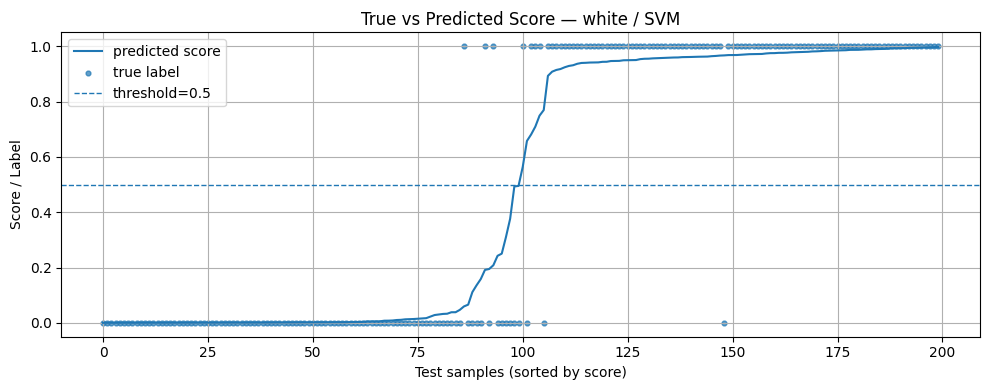

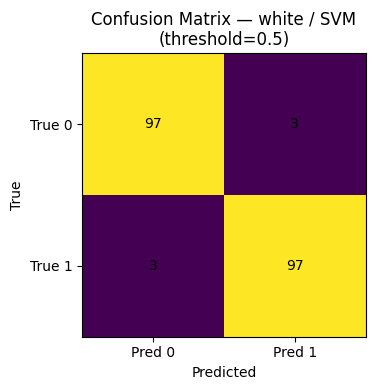

In [70]:
plot_true_vs_pred(all_results, noise_type="white", model_name="SVM", threshold=0.5)
# or for SVM decision_function (if you ever set probability=False), try threshold=0.0
# plot_true_vs_pred(all_results, "demo", "SVM", threshold=0.0)